## Rendu d'épreuve technique - Eclipse Flow

Par Matthias Molénat

Lundi 10 juin 2024


### Propos introductif et démarche


**Enoncé :**

Le cas pratique est un challenge data de type Kaggle. Tu trouveras joint un dossier zip comportant 3 files:
X_train.csv
X_test.csv 
y_train.csv


On attend de toi que tu produises un jupyter notebook ou autre notebook du même type où tu détailles et documentes ton approche. On attend aussi un fichier csv y_test.csv sur le même format que y_train.csv pour calculer ton score final. Tu pourras nous envoyer ces documents par mail quelques jours avant notre prochain entretien. L'objectif étant que tu ne passes pas plus de 3-4h dessus, on veut juste voir tes idées et comment tu réfléchis, tu nous feras une courte présentation lors de ton dernier entretien dans nos locaux.

L'objectif de ce cas est de prédire le spread Day-Ahead / Intraday, c'est-à-dire la différence de prix entre le marché Day-Ahead  et Intraday. L'enchère Day-Ahead a lieu la veille et détermine les prix au pas horaire du lendemain via une alors que le marché Intraday a lieu le jour même et trade en continu. Le prix Intraday est donc le prix moyen des trades alors que le prix Day-Ahead est le résultat d'une enchère. 

X_train: les inputs du modèle qui sont assez explicites
y_train: le spread Day-Ahead/Intraday pour une heure donnée
X_test: les inputs sur lesquels tu vas devoir faire tourner tes modèles

Quelques infos sur les données:
FR_DA_forecast (€/MWh): forecast de prix Day-Ahead France
DE_DA_forecast (€/MWh): forecast de prix Day-Ahead Allemagne

N'hésite pas à m'appeler si tu as des questions sur les données ou sur le cas.

Bien à toi,

--
Andrea Sannino
Co-Founder 
+33626131529


**Démarche :**

On souhaite prédire le spread en day-ahead à partir des données contenues dans les fichiers tests pour évaluation. On a à disposition les fichiers train pour éventuellement entrainer un modèle d'apprentissage supervisé.

Après avoir pris connaissance des données initales, on les traites : valeurs abérrantes, NaN, visualisation..

On cherche à identifier des features de choix : corrélation, intuition physique, visualisation de tendances et périodicités.

En se renseignant sur la problématique, j'ai trouvé l'article suivant :

https://www.researchgate.net/publication/337645629_Neural_Network_Based_Model_Comparison_for_Intraday_Electricity_Price_Forecasting (voir 2, 3.4, 3.8, Table 6, Table 7)

En guise de premier modèle, puis compte tenu de la structure des données et du temps imparti, je décide de tester un Neural Network similaire à celui testé dans l'article, prenant en compte : 
- des données d'entrées analogues à l'article : Day-ahead price forecast Fr & De, Forecast Renewables, Forecast demand
- la possibilité d'ajouter des informations complémentaires: information spécifiques  temporelles (week-end, vacances, heure, mois), spread lag

Avec un peu plus de temp, j'aurais aimé essayé d'autres approches
- Modèle non supervisé : ARIMA, régression polynomiale..
- Modèle supervisé : LSTM, RNN, GRU (voir article)

Ces modèles de prédiction seront ensuite évalué à partir d'un sous ensemble de data set Train pour améliorer les hypers-paramètres, puis évalués sur le data set Test pour évaluation finale. 

### Librairies

In [588]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns
sns.set_theme(rc={'figure.figsize':(15,8.27)})

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from statsmodels.tsa.arima.model import ARIMA

### Chargement des données

In [589]:
# Load data from CSV
X_test = pd.read_csv("DATA/X_test_df.csv")
X_train = pd.read_csv("DATA/X_train_df.csv")
Y_test = pd.read_csv("DATA/Y_test_df.csv")
Y_train = pd.read_csv("DATA/Y_train_df.csv")

### Visualisation, étude et traitement des données

In [590]:
# Prise de connaissance du dataset

print(X_train.columns.to_list())
print(Y_train.columns.to_list())
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

['start_date', 'Hydro_forecast (GW)', 'Solar_forecast (GW)', 'Wind_forecast (GW)', 'Wind_actual (GW)', 'Load_forecast (GW)', 'FR_DA_forecast (€/MWh)', 'DE_DA_forecast (€/MWh)', 'Is_Saturday', 'Is_Sunday', 'Is_Monday', 'Is_Holiday', 'Spread_lag_2', 'Spread_lag_3', 'Spread_lag_4', 'Spread_lag_5', 'Spread_lag_6', 'Spread_lag_7', 'Month', 'Day', 'Hour']
['start_date', 'Spread_DA/ID']
(1844, 21)
(1844, 2)
(2132, 21)
(2132, 2)


In [591]:
# Visualisation 

X_train.head()


,start_date,Hydro_forecast (GW),Solar_forecast (GW),Wind_forecast (GW),Wind_actual (GW),Load_forecast (GW),FR_DA_forecast (€/MWh),DE_DA_forecast (€/MWh),Is_Saturday,Is_Sunday,...,Is_Holiday,Spread_lag_2,Spread_lag_3,Spread_lag_4,Spread_lag_5,Spread_lag_6,Spread_lag_7,Month,Day,Hour
0,2023-07-11 02:00:00,-0.637213,-0.728061,-0.851210,-0.805235,-0.819749,0.568204,0.687065,0,0,...,0,-8,-6,-2,18,-54,-25,7,1,2
1,2023-07-11 03:00:00,-0.752418,-0.728061,-0.829835,-0.805235,-0.995320,0.494278,0.593648,0,0,...,0,-1,1,16,27,-13,0,7,1,3
2,2023-07-11 04:00:00,-0.814135,-0.728061,-0.829835,-0.755426,-1.041678,0.477904,0.497719,0,0,...,0,0,8,32,44,-12,39,7,1,4
3,2023-07-11 05:00:00,-0.797677,-0.725040,-0.825085,-0.750898,-0.917398,0.541234,0.548881,0,0,...,0,0,16,36,52,11,34,7,1,5
4,2023-07-11 06:00:00,-0.653670,-0.634412,-0.815585,-0.755426,-0.658975,0.783960,0.868416,0,0,...,0,-9,10,41,38,19,9,7,1,6


In [592]:
# Visualisation 

Y_train.tail()

,start_date,Spread_DA/ID
1839,2023-12-31 18:00:00,-0.140464
1840,2023-12-31 19:00:00,0.369413
1841,2023-12-31 20:00:00,-0.153859
1842,2023-12-31 21:00:00,0.237967
1843,2023-12-31 22:00:00,0.006052


In [593]:
# Visualisation 

X_test.tail()

,start_date,Hydro_forecast (GW),Solar_forecast (GW),Wind_forecast (GW),Wind_actual (GW),Load_forecast (GW),FR_DA_forecast (€/MWh),DE_DA_forecast (€/MWh),Is_Saturday,Is_Sunday,...,Is_Holiday,Spread_lag_2,Spread_lag_3,Spread_lag_4,Spread_lag_5,Spread_lag_6,Spread_lag_7,Month,Day,Hour
2127,2023-11-30 19:00:00,1.596947,-0.728061,-0.542461,-0.929758,2.137324,2.455594,2.952591,0,0,...,0,-20,-13,-19,5,-3,-25,11,3,19
2128,2023-11-30 20:00:00,1.708038,-0.728061,-0.549586,-0.911646,2.121543,2.251636,2.392319,0,0,...,0,-18,-16,-23,-2,-7,-20,11,3,20
2129,2023-11-30 21:00:00,1.564031,-0.728061,-0.563836,-0.882213,1.747716,1.585102,1.679931,0,0,...,0,-20,-5,-14,2,2,-18,11,3,21
2130,2023-11-30 22:00:00,1.292476,-0.728061,-0.599461,-0.877685,1.469566,1.200544,1.295301,0,0,...,0,-23,-11,-19,0,-4,-31,11,3,22
2131,2023-11-30 23:00:00,1.169042,-0.728061,-0.632711,-0.913910,1.426167,0.946982,0.955210,0,0,...,0,-18,-3,-8,-9,-5,-4,11,3,23


In [594]:
# Vérification de la présence de NaN Values
 
total_nans_X_train = X_train.isna().sum().sum()
total_nans_Y_train = Y_train.isna().sum().sum()
total_nans_X_test = X_test.isna().sum().sum()
total_nans_X_test = Y_test.isna().sum().sum()
print(f'Le nombre total de NaNs dans [X_train, Y_train, X_test, Y_test] sont : {total_nans_X_train,total_nans_Y_train,total_nans_X_test,total_nans_X_test}')

Le nombre total de NaNs dans [X_train, Y_train, X_test, Y_test] sont : (0, 0, 0, 0)


In [595]:
# Vérification de la concordence X <-> Y et création d'une fusion 

merged_train_df = pd.merge(X_train, Y_train, on='start_date', how='inner')
print(merged_train_df.shape)
merged_train_df.head()


(1844, 22)


,start_date,Hydro_forecast (GW),Solar_forecast (GW),Wind_forecast (GW),Wind_actual (GW),Load_forecast (GW),FR_DA_forecast (€/MWh),DE_DA_forecast (€/MWh),Is_Saturday,Is_Sunday,...,Spread_lag_2,Spread_lag_3,Spread_lag_4,Spread_lag_5,Spread_lag_6,Spread_lag_7,Month,Day,Hour,Spread_DA/ID
0,2023-07-11 02:00:00,-0.637213,-0.728061,-0.851210,-0.805235,-0.819749,0.568204,0.687065,0,0,...,-8,-6,-2,18,-54,-25,7,1,2,0.125359
1,2023-07-11 03:00:00,-0.752418,-0.728061,-0.829835,-0.805235,-0.995320,0.494278,0.593648,0,0,...,-1,1,16,27,-13,0,7,1,3,0.986036
2,2023-07-11 04:00:00,-0.814135,-0.728061,-0.829835,-0.755426,-1.041678,0.477904,0.497719,0,0,...,0,8,32,44,-12,39,7,1,4,2.159841
3,2023-07-11 05:00:00,-0.797677,-0.725040,-0.825085,-0.750898,-0.917398,0.541234,0.548881,0,0,...,0,16,36,52,11,34,7,1,5,2.082396
4,2023-07-11 06:00:00,-0.653670,-0.634412,-0.815585,-0.755426,-0.658975,0.783960,0.868416,0,0,...,-9,10,41,38,19,9,7,1,6,0.839102


<Axes: >

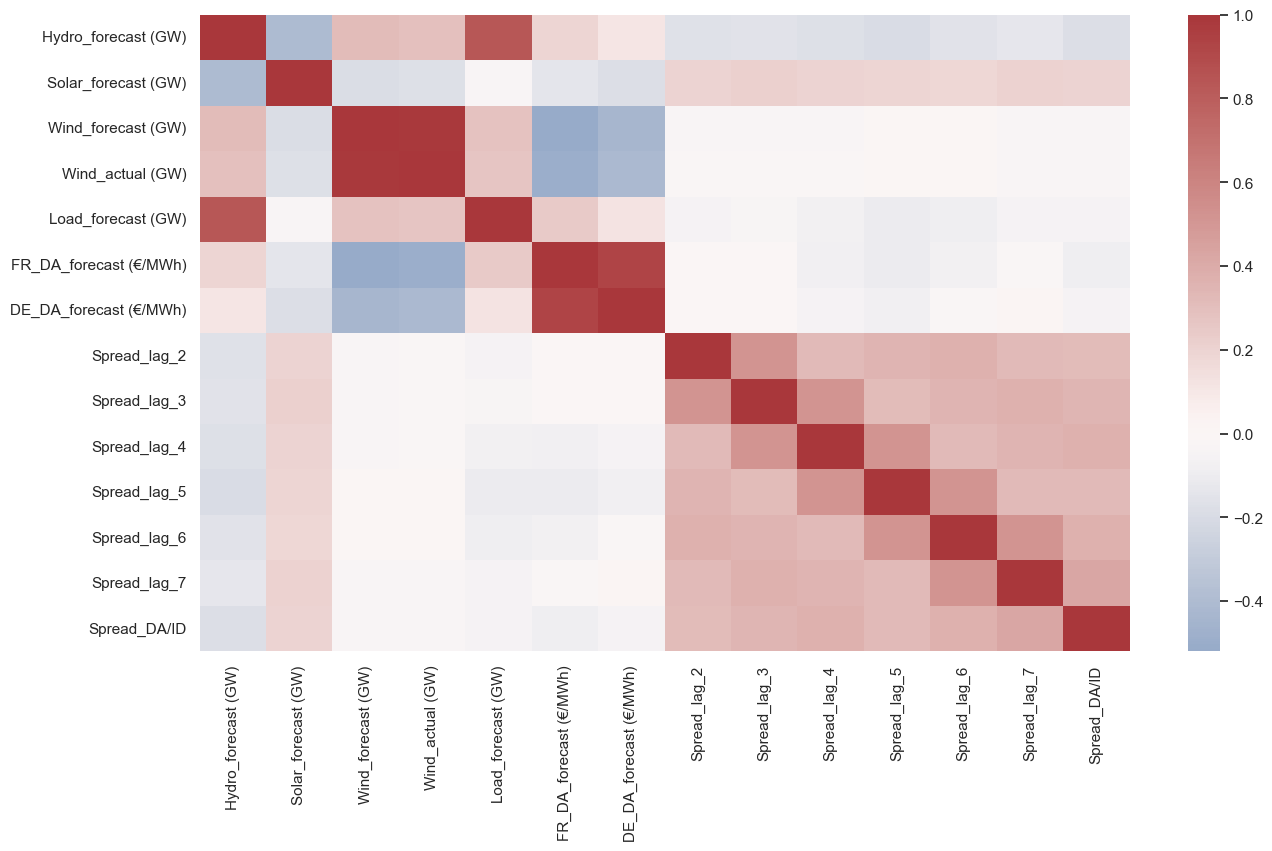

In [596]:
# Visualisation de la corrrélation des time-series

df = merged_train_df[[ 'Hydro_forecast (GW)', 'Solar_forecast (GW)', 'Wind_forecast (GW)', 'Wind_actual (GW)', 'Load_forecast (GW)', 'FR_DA_forecast (€/MWh)', 'DE_DA_forecast (€/MWh)', 'Spread_lag_2', 'Spread_lag_3', 'Spread_lag_4', 'Spread_lag_5', 'Spread_lag_6', 'Spread_lag_7', 'Spread_DA/ID']]
corr = df.corr(method='pearson')
sns.heatmap(corr,cmap="vlag",center=0)

Remarque possible : 
- Correlation positive 

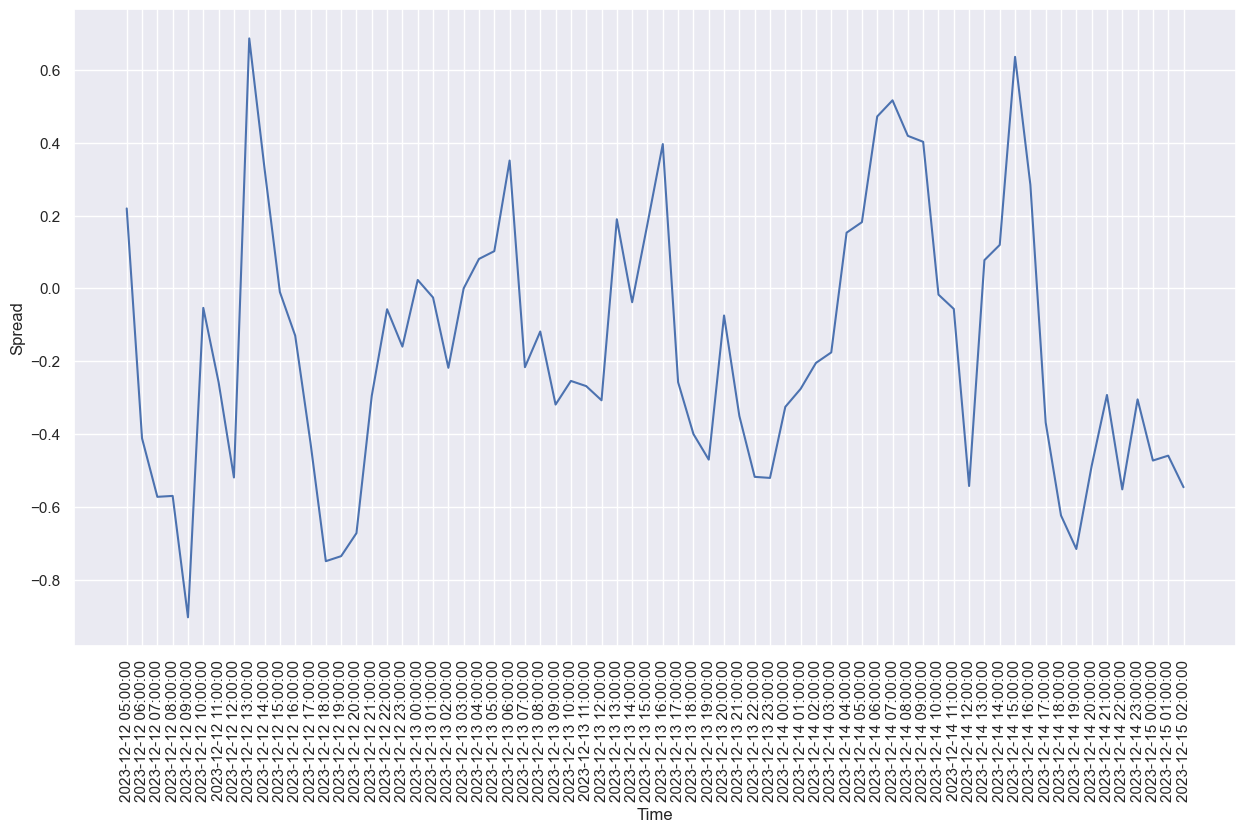

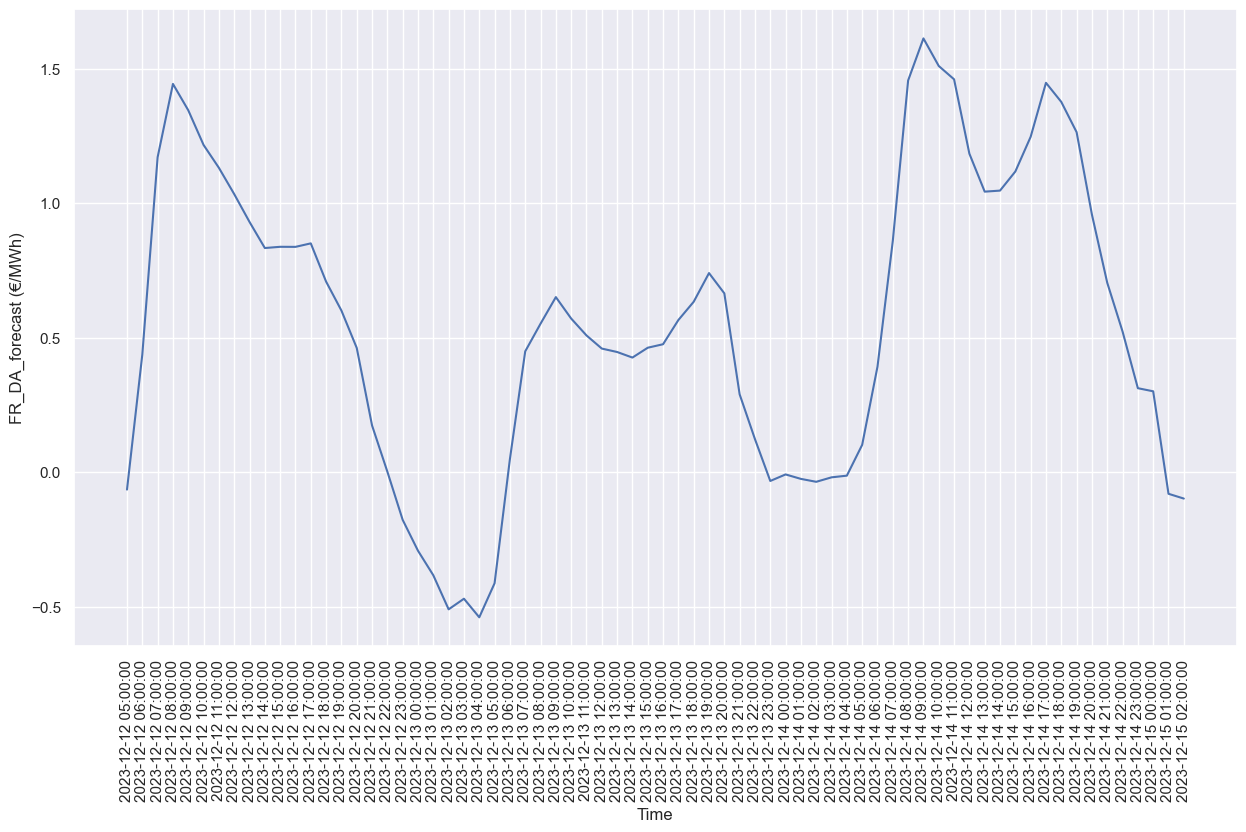

In [597]:
# Visualisation du spreads : valeurs, tendances

window_size = 70
start_point = np.random.randint(0,1800)

plt.plot(merged_train_df["start_date"][start_point:start_point+window_size],merged_train_df["Spread_DA/ID"][start_point:start_point+window_size])
plt.xlabel("Time")
plt.ylabel("Spread")
plt.xticks(rotation=90)
plt.show()

plt.plot(merged_train_df["start_date"][start_point:start_point+window_size],merged_train_df["FR_DA_forecast (€/MWh)"][start_point:start_point+window_size])
plt.xlabel("Time")
plt.ylabel("FR_DA_forecast (€/MWh)")
plt.xticks(rotation=90)
plt.show()

# On semble identifier des pics spreads autour des heures 6 am et 5 pm

Visualisation des données en boites à moustaches : dispersions, valeurs abérrantes éventuelles...

<Axes: >

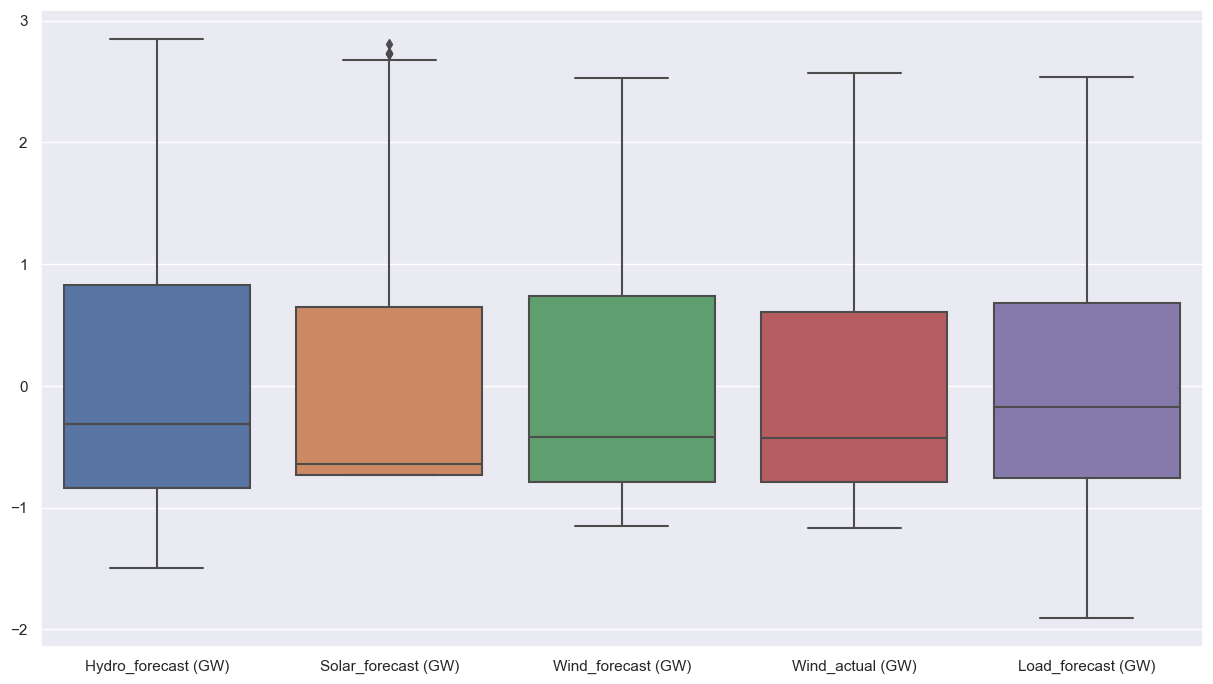

In [598]:
sns.boxplot(data=X_train[['Hydro_forecast (GW)', 'Solar_forecast (GW)', 'Wind_forecast (GW)', 'Wind_actual (GW)', 'Load_forecast (GW)']])

<Axes: >

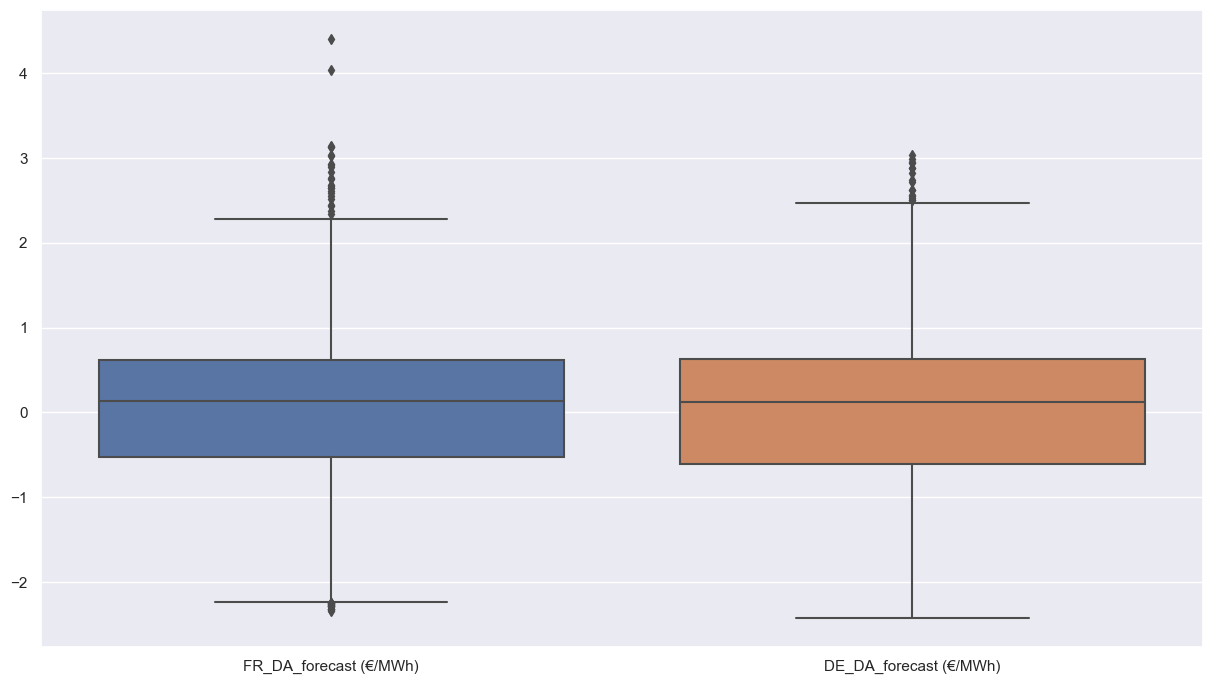

In [599]:
sns.boxplot(data=X_train[['FR_DA_forecast (€/MWh)', 'DE_DA_forecast (€/MWh)']])


<Axes: >

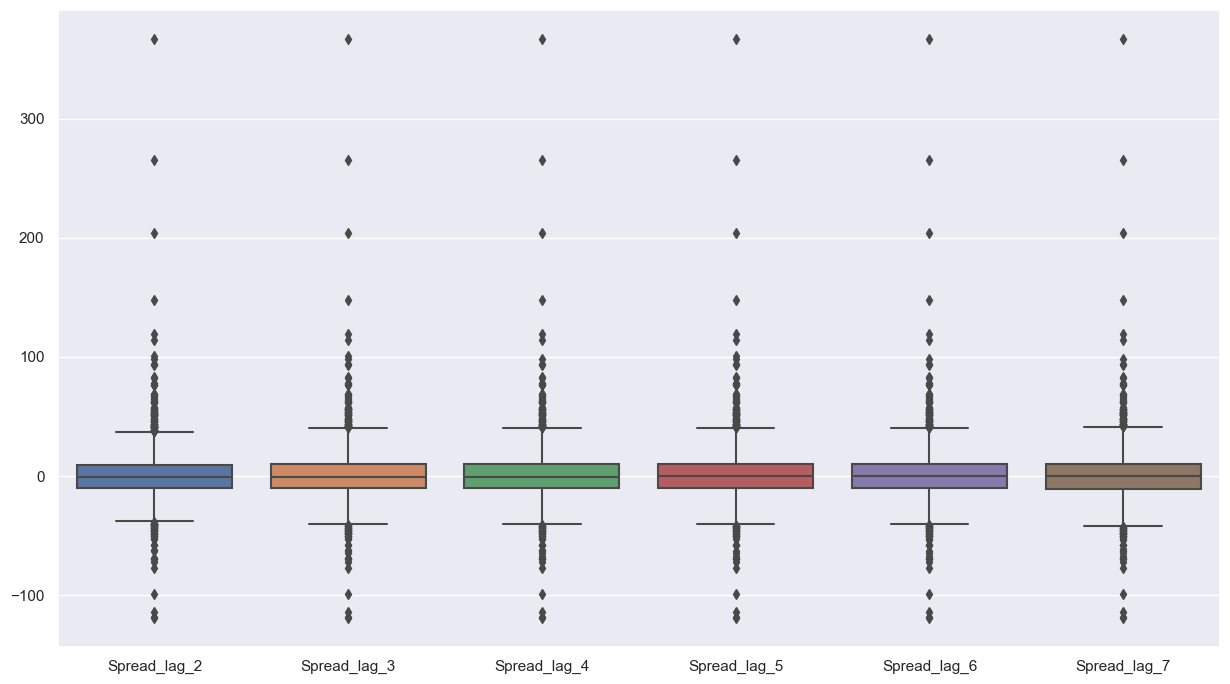

In [600]:
sns.boxplot(data=X_train[['Spread_lag_2', 'Spread_lag_3', 'Spread_lag_4', 'Spread_lag_5', 'Spread_lag_6', 'Spread_lag_7']])


<Axes: >

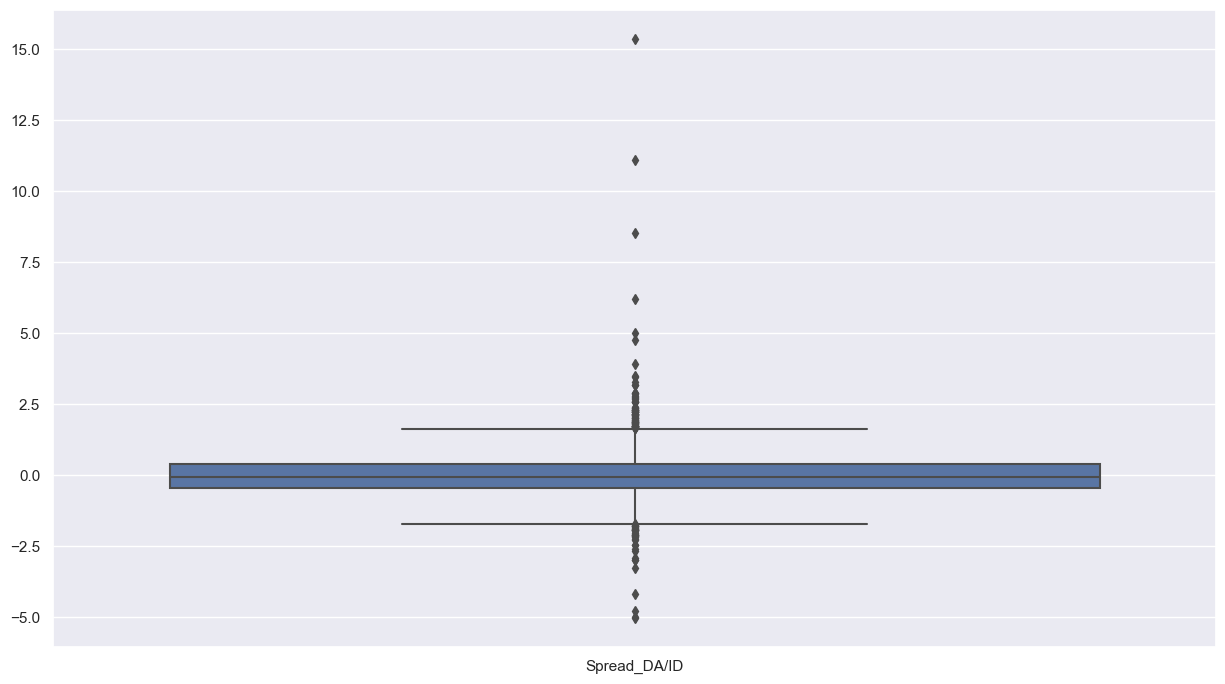

In [601]:
sns.boxplot(data=Y_train[[ 'Spread_DA/ID']])

In [602]:
# Angularisation des entrées horaires. Possible aussi pour day.

#Add angular day of the week
X_train['Month_cos'] = np.sin(X_train['Month'] * (2 * np.pi / 12))
X_train['Month_sin'] = np.cos(X_train['Month'] * (2 * np.pi / 12))
X_test['Month_cos'] = np.sin(X_test['Month'] * (2 * np.pi / 12))
X_test['Month_sin'] = np.cos(X_test['Month'] * (2 * np.pi / 12))

#Add angular hour
X_train['Hour_cos'] = np.sin(X_train['Hour'] * (2 * np.pi / 24))
X_train['Hour_sin'] = np.cos(X_train['Hour'] * (2 * np.pi / 24))
X_test['Hour_cos'] = np.sin(X_test['Hour'] * (2 * np.pi / 24))
X_test['Hour_sin'] = np.cos(X_test['Hour'] * (2 * np.pi / 24))

time_ftres = [ 'Month_cos', 'Month_sin', 'Hour_cos', 'Hour_sin']



### Modéles d'apprentissages

##### **ARIMA** (avorté)

In [603]:
# spread_lag_test = X_test[['Spread_lag_2', 'Spread_lag_3', 'Spread_lag_4', 'Spread_lag_5', 'Spread_lag_6', 'Spread_lag_7']]
# spread_test= Y_test['Spread_DA/ID'].values.reshape(-1, 1)

# # Scale the input data using standardization
# scaler_lag = StandardScaler()
# spread_lag_test_array = scaler_lag.fit_transform(spread_lag_test)

# scaler_spread = StandardScaler()
# spread_test = scaler_spread.fit_transform(spread_test)

In [604]:
# print(spread_lag_test_array)
# print(spread_test)
# spread_lag_test_df = pd.DataFrame(spread_lag_test_array,columns=spread_lag_test.columns)
# spread_lag_test_df.head()

Arima over lag spread

In [605]:
# def arima_forecaster(df):
#     """
#     Fits an ARIMA model for each asset and returns the mean value of the one-step-ahead forecast.
#     """

#     forecasts = []
    

#     # Fitting an ARIMA model for each asset
#     for index, x in df.iterrows():
#         model = ARIMA(x, order=(1,0,1))  # Adjust ARIMA order as needed
#         results = model.fit()

#         # Forecasting one step ahead
#         forecast = results.get_forecast(steps=1)
#         forecasts.append(forecast)

#     # Creating a DataFrame with the mean forecast values
#     forecast_df = pd.DataFrame(np.array(forecasts))

#     return forecast_df

In [606]:
# Y_predicted  = arima_forecaster(spread_lag_test)

#### **Neural Networks**

In [607]:
# Définitions de différentes features prises en comptes. Aide à la décision : travail préliminaire. 
# Autre aide possible : étude des poids dans une régréssion linéaire simple avec régulateur (Lasso p.e.)
 
features1 = ['Hydro_forecast (GW)', 
            'Solar_forecast (GW)', 
            'Wind_forecast (GW)', 
            'Load_forecast (GW)',
            'FR_DA_forecast (€/MWh)',
            'DE_DA_forecast (€/MWh)',
            'Hour_cos','Hour_sin',
            'Spread_lag_2', 'Spread_lag_3',
            'Spread_lag_4', 'Spread_lag_5',
            'Spread_lag_6', 'Spread_lag_7']

features2 = ['Spread_lag_2', 'Spread_lag_3',
            'Spread_lag_4', 'Spread_lag_5',
            'Spread_lag_6', 'Spread_lag_7',
            'Hour_cos','Hour_sin']

# Chois de features pour la suite
features = features2
n_fit = len(features)

In [608]:
# Gestion des données pour travail avec NN. Tenseurs en train - test (depuis 'train') - évaluation (fichier 'test'),
# pour éviter de biaisé le NN sur le set d'évaluation

X_train_NN = X_train[features].values
Y_train_NN = Y_train['Spread_DA/ID'].values.reshape(-1, 1)

X_test_NN = X_test[features].values
Y_test_NN = Y_test['Spread_DA/ID'].values.reshape(-1, 1)


# Split the data into training and testing sets
X_train_NN, X_val_NN, Y_train_NN, Y_val_NN = train_test_split(
    X_train_NN, Y_train_NN, test_size=0.2, random_state=42
)

# Scale the input data using standardization
scaler = StandardScaler()
X_train_NN = scaler.fit_transform(X_train_NN)
X_val_NN = scaler.transform(X_val_NN)
X_test_NN = scaler.fit_transform(X_test_NN)

scaler_Y = StandardScaler()
Y_train_NN = scaler_Y.fit_transform(Y_train_NN)
Y_val_NN = scaler_Y.transform(Y_val_NN)
Y_test_NN = scaler_Y.transform(Y_test_NN)


In [609]:
class Net_percep(nn.Module): # NN perceptron 1 hidden layer 1 neuron

    def __init__(self):
        super(Net_percep, self).__init__()
        self.entry = nn.Linear(n_fit, 1)
        self.act1 = nn.Tanh()
        self.exit = nn.Linear(1,1)


    def forward(self, x):
        out = self.entry(x)
        out = self.act1(out)
        out = self.exit(out)
        return out

class Net1(nn.Module): # relatif à l'article

    def __init__(self):
        super(Net1, self).__init__()
        self.entry = nn.Linear(n_fit, n_fit)
        self.fc1 = nn.Linear(n_fit, n_fit)
        self.fc2 = nn.Linear(n_fit,n_fit)
        self.exit = nn.Linear(n_fit,1)


    def forward(self, x):
        out = self.entry(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.exit(out)
        return out

class Net2(nn.Module): # Test NN intermédiaire

    def __init__(self):
        super(Net2, self).__init__()
        self.entry = nn.Linear(n_fit, n_fit)
        self.act1 = nn.Tanh()
        self.fc1 = nn.Linear(n_fit, 1)
        self.act2 = nn.Tanh()
        self.exit = nn.Linear(1,1)


    def forward(self, x):
        out = self.entry(x)
        out = self.act1(out)
        out = self.fc1(out)
        out = self.act2(out)
        out = self.exit(out)
        return out


# Create an instance of the neural network model
model = Net_percep()

In [610]:

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert the training data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_NN, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_NN, dtype=torch.float32)

Entrainement

In [611]:
loss_history = []
# Train the model 
for epoch in range(5000):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    output = model(X_train_tensor)
    loss = criterion(output, Y_train_tensor)
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    loss_history.append(float(loss))
    # Print training loss for every 10 epochs
    if (epoch + 1) % 100 == 0:

        print(f"Epoch {epoch+1}, loss: {loss.item()}")

Epoch 100, loss: 1.0932729244232178
Epoch 200, loss: 0.871788740158081
Epoch 300, loss: 0.7870209813117981
Epoch 400, loss: 0.7563223242759705
Epoch 500, loss: 0.7431815266609192
Epoch 600, loss: 0.7356244921684265
Epoch 700, loss: 0.7299084663391113
Epoch 800, loss: 0.7250695824623108
Epoch 900, loss: 0.7208766937255859
Epoch 1000, loss: 0.7172133922576904
Epoch 1100, loss: 0.7139905691146851
Epoch 1200, loss: 0.7111471891403198
Epoch 1300, loss: 0.7086401581764221
Epoch 1400, loss: 0.7064311504364014
Epoch 1500, loss: 0.7044816017150879
Epoch 1600, loss: 0.7027532458305359
Epoch 1700, loss: 0.7012099623680115
Epoch 1800, loss: 0.6998181939125061
Epoch 1900, loss: 0.6985477209091187
Epoch 2000, loss: 0.697372317314148
Epoch 2100, loss: 0.6962685585021973
Epoch 2200, loss: 0.6952163577079773
Epoch 2300, loss: 0.6941997408866882
Epoch 2400, loss: 0.693205714225769
Epoch 2500, loss: 0.6922257542610168
Epoch 2600, loss: 0.6912554502487183
Epoch 2700, loss: 0.690295398235321
Epoch 2800, lo

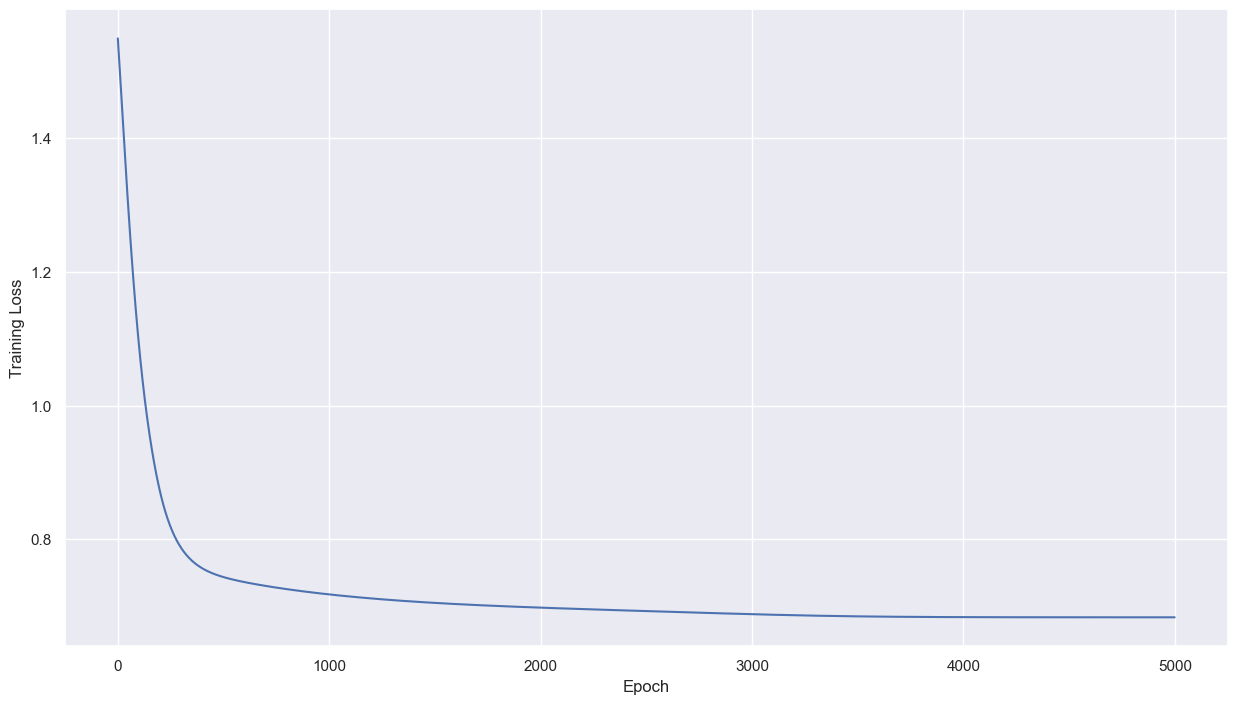

In [612]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

### Tests et performances à partir de X_val & Y_val


In [613]:
# Evaluate the model on the validation set
with torch.no_grad():
    # Convert the testing data to PyTorch tensors
    X_val_tensor = torch.tensor(X_val_NN, dtype=torch.float32)
    Y_val_tensor = torch.tensor(Y_val_NN, dtype=torch.float32)

    # Make predictions on the testing set
    predictions = model(X_val_tensor)

    # Calculate the testing loss (mean squared error)
    test_loss = criterion(predictions, Y_val_tensor)
    print(f"Testing loss: {test_loss.item()}")

Testing loss: 0.49724605679512024


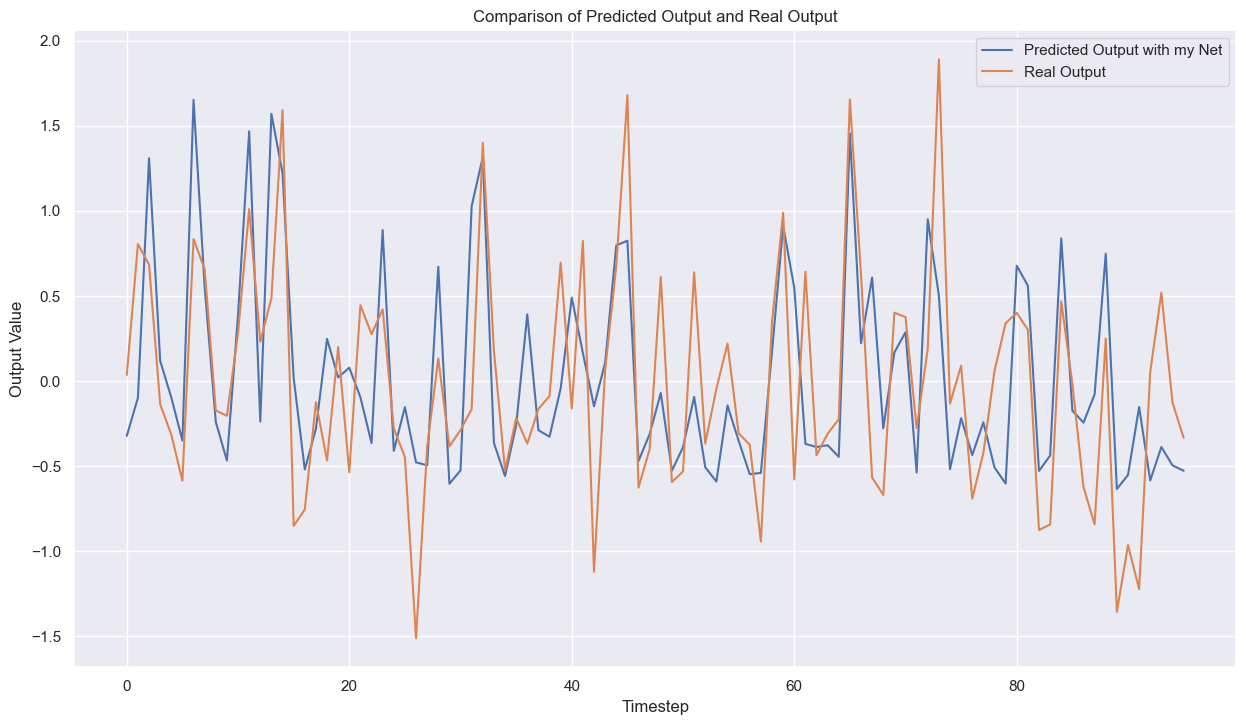

In [621]:
# Set the model to evaluation mode
model.eval()

output_tensor_MyNet = model(X_val_tensor)

Y_output_MyNet= scaler_Y.inverse_transform(output_tensor_MyNet.detach())


plt.plot(Y_output_MyNet[:96], label="Predicted Output with my Net")
plt.plot(Y_val_NN[:96], label="Real Output") 
plt.xlabel("Timestep")
plt.ylabel("Output Value")
plt.title("Comparison of Predicted Output and Real Output")
plt.legend()
plt.show()

TEST pour produire CSV final

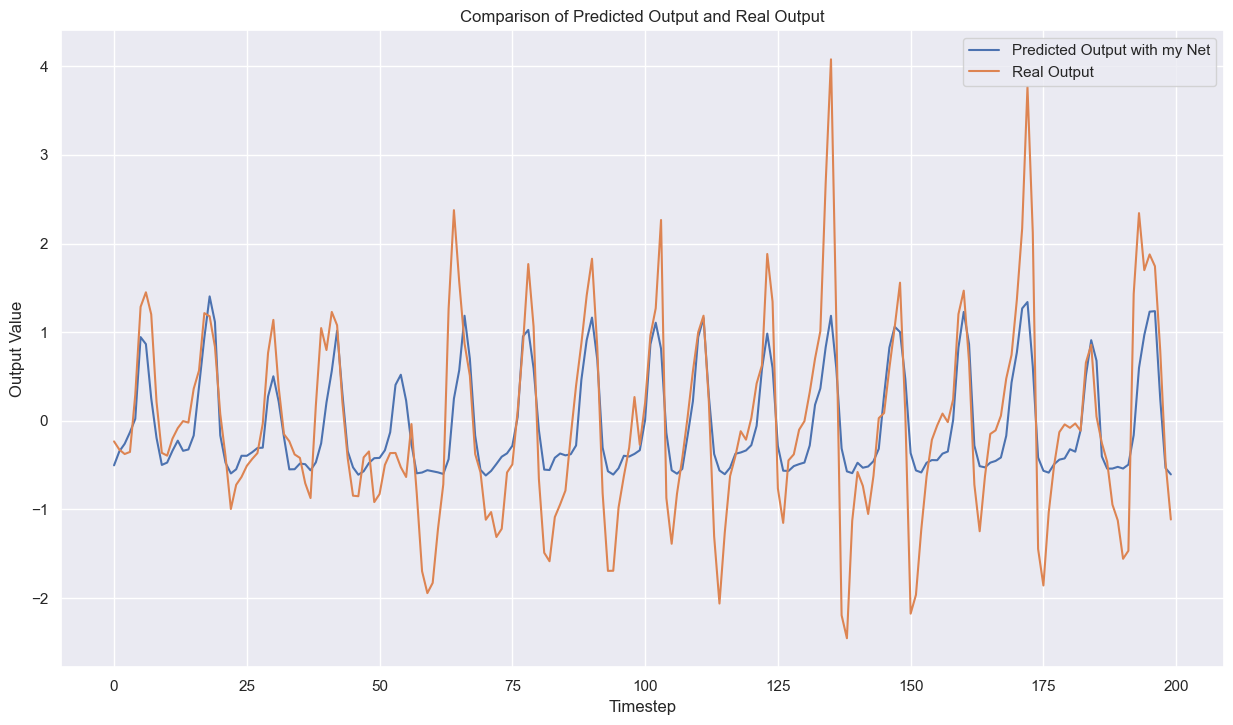

In [615]:
X_test_tensor = torch.tensor(X_test_NN, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_NN, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

output_tensor_MyNet = model(X_test_tensor)

Y_output_MyNet= scaler_Y.inverse_transform(output_tensor_MyNet.detach())


plt.plot(Y_output_MyNet[:200], label="Predicted Output with my Net")
plt.plot(Y_test_NN[:200], label="Real Output") 
plt.xlabel("Timestep")
plt.ylabel("Output Value")
plt.title("Comparison of Predicted Output and Real Output")
plt.legend()
plt.show()

In [616]:
# Calculate MAE
mae = np.mean(np.abs(Y_test_NN - Y_output_MyNet))
print(f'mae =  {mae}')

# Calculate RMSE
rmse = np.sqrt(np.mean((Y_test_NN - Y_output_MyNet) ** 2))
print(f'rmse =  {rmse}')

mae =  0.607685432083651
rmse =  0.8413975750379136


In [617]:
np.savetxt("Prediction.csv", Y_output_MyNet, delimiter=",")

### Bilan

Les résultats sur les différents tests sont :

|  (MAE/RMSE)| Net_percep | Net1 | Net2 |
|------------|------------|------|------|
| Features 1 | (0,62 / 0,84)  |  (0,63 / 0,87)    |  (0,83 / 1,01)    |
| Features 2 |  (0,60 / 0,83)          |  (0,61 / 0,85)    |   (0,63 / 0,87)   |


On arrive a capturer les tendances périodiques du spreads notamment grâce à l'ajout de l'information horaire.


L'ensemble Features 2 telle que définie perfome mieux que Features 1 : on considére le spread en time series uniquement. On pourrait imaginer tester d'autres features donnant des détails 

Remarque : Avec les features 1, un perceptron performe mieux que le NN insipiré de l'article. Il est aussi plus simple à interpréter et plus rapide à entrainer.

A la lumière des remarques précédentes et des indicateurs MAE/RMSE, le fichier .csv rendu correspond au NN Net_percep avec Features 2.

### Travaux futurs possibles

- Optimisation d'hyper-paramètres : choix des features, fonctions d'activations, epoch, learning-rate, criterion.. pour essayer, par exemple,   de mieux capturer la tendance du spread (dans les négatifs p.e.)
- Test d'autres modèles.
- Changer de paradigme de prédiction : prédire ID au lieu de DA/ID, puis faire les maths.
- Gestion des données pour mettre en place un apprentissage avec fenetre roulante.